# Discovery techniques

Querying the database can be done with anything which support attaching to a PostGreSQL database. Many interface libraries for a variety of programming languages exist, so this is in the end a user's choice.

That being said, often there are queries which need to be done more often, and it pays off to build convenience functions which wrap a database query. Commonly used query wrapper are found in the [discover subdirectory](../references/geoslurp.discover.html#module-geoslurp.discover). 

Below are a few examples which demonstrate the use of sqlalchemy to perform queries. They make use of the data which has been registered in [this notebook](../notebooks/CreateDynDSet.html#Download-and-register-a-dataset-of-(fictious?)-US-Marijuana-street-prices). The queries are encapsulated in functions which return an iteratable object which is the result of the query. This is also the same pattern as most functions in the  *discover* directory obey.

In [1]:
from geoslurp.config import setInfoLevel
from geoslurp.db import geoslurpConnect
setInfoLevel()

gpcon=geoslurpConnect() # this will be a connection based on the readonly user

## Query a single table and visualize the result

In [2]:
from sqlalchemy import select,asc
def queryState(dbcon,state):
    """Query the usweedprices2 table for a given state, while sorting the results according to their timestamp"""
    #retrieve/reflect the table (note the lowercase table name)
    tbl=dbcon.getTable('usweedprices2','public')

    qry=select([tbl]).where(tbl.c.State == state).order_by(asc(tbl.c.date))
    
    return dbcon.dbeng.execute(qry)

### Pick a state and plot the results using matplotlib

Text(0.5, 0, 'date')

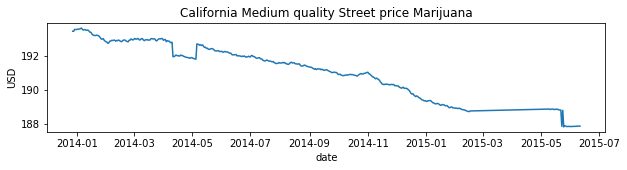

In [3]:
import matplotlib.pyplot as mpl
from datetime import datetime
%matplotlib inline

statename="California"

t=[]
medq=[]
for entry in queryState(gpcon,statename):
    t.append(datetime.strptime(entry.date, "%Y-%m-%d"))
    medq.append(entry.MedQ)


fig,ax=mpl.subplots(figsize=(10,2))
ax.plot(t,medq)
mpl.ylabel("USD")
mpl.title("%s Medium quality Street price Marijuana"%statename)
mpl.xlabel("date")

## A more complicated query which joins data between tables
Imagine you want to geographically compare the average street price in 2024 between US states, and geographically visualize this.

This requires a query which computes the average per State and an inner join with a table which contains the polygons of the states.

In [4]:
from sqlalchemy.sql import join,func
def queryAveragePerState(dbcon):
    
    #find the two relevant tables
    usw=dbcon.getTable('usweedprices2','public')
    stategeo=dbcon.getTable('ne_110m_admin_1_states_provinces','globalgis')
    
    #create a subquery with averages per state
    subqry1=select([usw.c.State,func.avg(usw.c.MedQ).label("avg")]).group_by(usw.c.State).alias("uswt")
    
    #join the subquery with polygon data from the stategeo table
    j=join(subqry1,stategeo,subqry1.c.State == stategeo.c.name)
   
    qry=select([subqry1.c.State,subqry1.c.avg,stategeo.c.geom]).select_from(j)

    return dbcon.dbeng.execute(qry)

        

### Visualize the result geographically using matplotlib

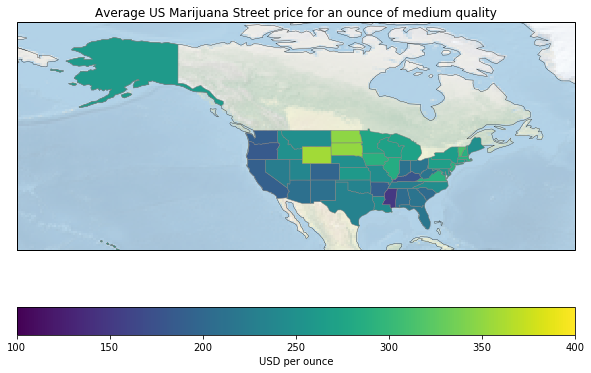

In [6]:
import cartopy.crs as ccrs
import cartopy
from geoslurp.tools.shapelytools import shpextract
from cartopy.feature import ShapelyFeature


cmap = mpl.cm.viridis
proj=ccrs.EquidistantConic(central_longitude=-100.0, central_latitude=37.5, standard_parallels=(30.0, 45.0))
proj=ccrs.PlateCarree()
mpl.figure(figsize=(10,7))
ax = mpl.axes(projection=proj)
ax.set_extent((-180., -45., 20.,75.),crs=ccrs.PlateCarree())
background=ax.stock_img()
background.set_alpha(0.6)
ax.coastlines(linewidth=0.3)
minprice=100
maxprice=400
for entry in queryAveragePerState(gpcon):
    geom=ShapelyFeature([shpextract(entry)],crs=ccrs.PlateCarree(),edgecolor='gray',facecolor=cmap((entry.avg-minprice)/(maxprice-minprice)),zorder=10,linewidth=0.5)
    ax.add_feature(geom)

    
sm = mpl.cm.ScalarMappable(cmap=cmap,norm=mpl.Normalize(minprice,maxprice))
sm._A = []
cbar=mpl.colorbar(sm,ax=ax,orientation='horizontal')    
cbar.set_label("USD per ounce")
mpl.title("Average US Marijuana Street price for an ounce of medium quality")
mpl.show()
